In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import sdeint
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pycatch22 as catch22
from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp
from odes import *

## Exploration of the Catch22 Instance Space (in a small set of dynamical regimes)
# (**This is a subsection of DP1 - the instances/systems**)

Aim is to understand whether the instance space is able to discern qualitatively different dynamics and cluster/group those with similar dynamics. This will be done by:
> - (I) Identifying several distinct regimes in both the Hopf and Bistable systems.
> - (II) Generating time series for each, fixed length, 5000 timepoints with 3 noise levels
> - (III) Extract Features with Catch22
> - (IV) Project into instance space with PCA
> - (V) Explore similarities between regimes with qualitatively similar dynamics 



In [4]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## Hopf Normal Form

The Normal Form of the Hopf Bifurcation in XY coordinates is given by:
$$\dot{x} = - y + (\mu - x^2 - y^2)x$$
$$\dot{y} = x + (\mu - x^2 - y^2)y$$
Where $\mu$ is a control parameter. First, we will plot the Hopf bifurcation to understand the different regimes:

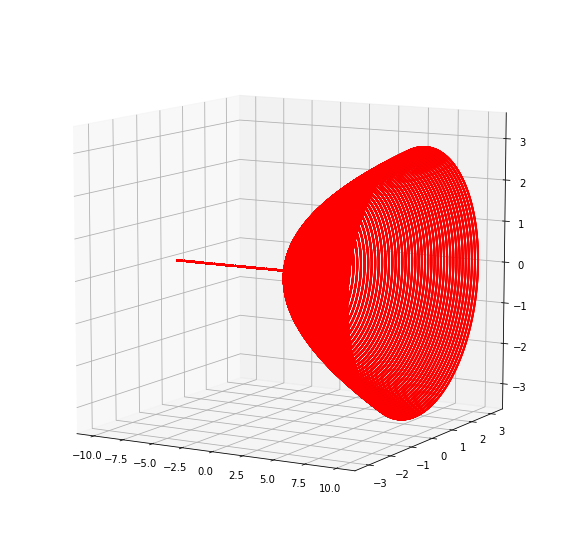

In [6]:
mus = np.linspace(-10, 10, 100)
x0 = np.random.uniform(-1, 1, size=(1,2))[0]
dt = 0.01
t = np.arange(0, 100, dt)
t_span = (t[0], t[-1])
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
for mu in mus:
    x = solve_ivp(HopfNormalForm.rhs, t_span, x0, t_eval=t, args=[mu], **integrator_keywords).y.T
    ax.scatter3D(mu, x[2000:,0], x[2000:,1], color='red', s=1) # discard transients to get cleaner plot
ax.view_init(elev=10, azim=300)
plt.show()


## 2D Bifurcation Diagram

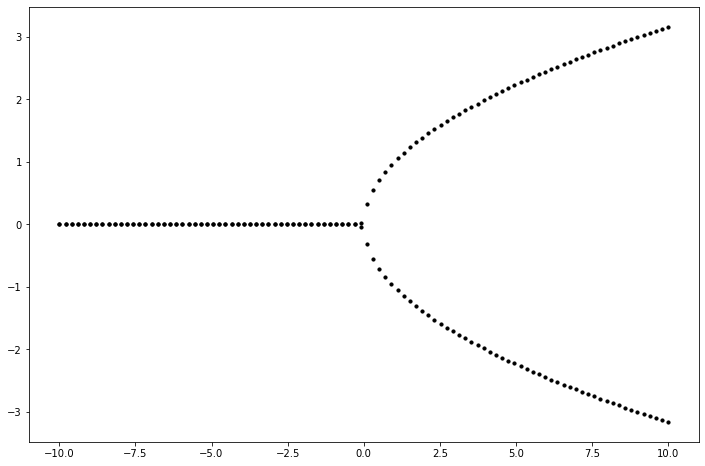

In [14]:
plt.figure(figsize=(12,8))
dt = 0.01
t = np.arange(0, 100, dt)
t_span = (t[0], t[-1])
for mu in mus:
    x = solve_ivp(HopfNormalForm.rhs, t_span, x0, t_eval=t, args=[mu], **integrator_keywords).y.T
    plt.scatter(mu, np.max(x[2000:,0]), color='k', s=10) # discard transients to get cleaner plot
    plt.scatter(mu, np.min(x[2000:,0]), color='k', s=10)
plt.show()

#### We will select 5 regimes:
- $\mu = -10$ -> fixed point attractor regime
- $\mu = -\epsilon$ -> close and left to the Hopf Bifurcation point 
- $\mu = 0$ - At the Hopf Bifurcation point - stable oscillations (not limit cycle)
- $\mu = \epsilon$ -> close and right of the Hopf Bifurcation point
- $\mu = 10$ -> limit cycle attractor regime


### 1. $\mu = -10$ (1 Noise level for now)

In [447]:
ic = [0.1, 0.1]
noise = 0.01
dt = 0.01
# Test integrate with noise:
# Define deterministic part
def f(state, t):
    mu = -10
    x, y = state[0], state[1]
    dxdt = - y + (mu - x ** 2 - y ** 2) * x
    dydt = x + (mu - x ** 2 - y ** 2) * y
    return dxdt, dydt
ic = np.array(ic)
tspan = np.arange(0, 50, dt)
gw = lambda y, t: noise * np.diag(ic) # noise is relative to ic's 
fw = lambda y, t: np.array(f(y,t))
result = sdeint.itoint(fw, gw, np.array(ic), tspan)


### Generate ensemble of 10 ICs

In [448]:
random.seed(9858)
n_samples = 10
ic_initial = [0.8, 0.3]
frac_perturb = 0.8 # fraction (of the ics) to perturb initial conditions by
ics = np.zeros((10, 2))
for i in range(n_samples):
    ic_perturb = 1 + frac_perturb * (2 * np.random.random(len(ic_initial))-1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new

In [449]:
noise = 0.01 # noise amplitude as fraction of ics
dt = 0.01
def f(state, t):
    mu = -10
    x, y = state[0], state[1]
    dxdt = - y + (mu - x ** 2 - y ** 2) * x
    dydt = x + (mu - x ** 2 - y ** 2) * y
    return dxdt, dydt
tspan = np.arange(0, 50, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)


# Plot Time Series and Phase Portraits of Noisy Ensemble

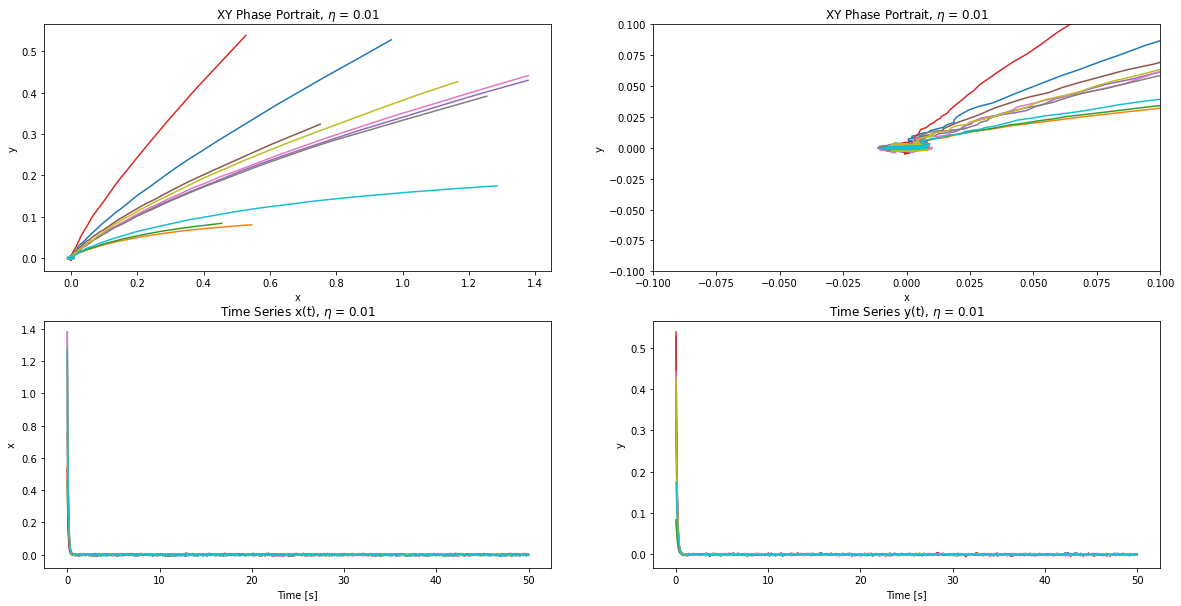

In [450]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
[ax[0,0].plot(sol_list[i][:,0], sol_list[i][:,1]) for i in range(10)]
[ax[0,1].plot(sol_list[i][:,0], sol_list[i][:,1]) for i in range(10)]
ax[0,1].set_xlim([-0.1, 0.1])
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')
ax[0,0].set_title(f'XY Phase Portrait, $\eta$ = {noise}')
ax[0,1].set_title(f'XY Phase Portrait, $\eta$ = {noise}')
ax[1,0].set_title(f'Time Series x(t), $\eta$ = {noise}')
ax[1,1].set_title(f'Time Series y(t), $\eta$ = {noise}')
ax[0,1].set_ylim([-0.1, 0.1])
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('y')
[ax[1, 0].plot(tspan, sol_list[i][:,0]) for i in range(10)]
ax[1,0].set_xlabel('Time [s]')
ax[1,0].set_ylabel('x')
[ax[1, 1].plot(tspan, sol_list[i][:,1]) for i in range(10)]
ax[1,1].set_xlabel('Time [s]')
ax[1,1].set_ylabel('y')
plt.show()

So after the brief transient, the noisy trajectories are all attracting onto a fixed point at the origin (as expected) about which they deviate. Noise level here is 0.01.

In [451]:
TS_HOPF_MU_N10 = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

### 2. $\mu = -0.1$

In [452]:
random.seed(58)
n_samples = 10
ic_initial = [0.8, 0.3]
frac_perturb = 0.8 # fraction (of the ics) to perturb initial conditions by
ics = np.zeros((10, 2))
for i in range(n_samples):
    ic_perturb = 1 + frac_perturb * (2 * np.random.random(len(ic_initial))-1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new

In [453]:
noise = 0.01 # noise amplitude as fraction of ics
dt = 0.01
def f(state, t):
    mu = -0.1
    x, y = state[0], state[1]
    dxdt = - y + (mu - x ** 2 - y ** 2) * x
    dydt = x + (mu - x ** 2 - y ** 2) * y
    return dxdt, dydt
tspan = np.arange(0, 50, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)

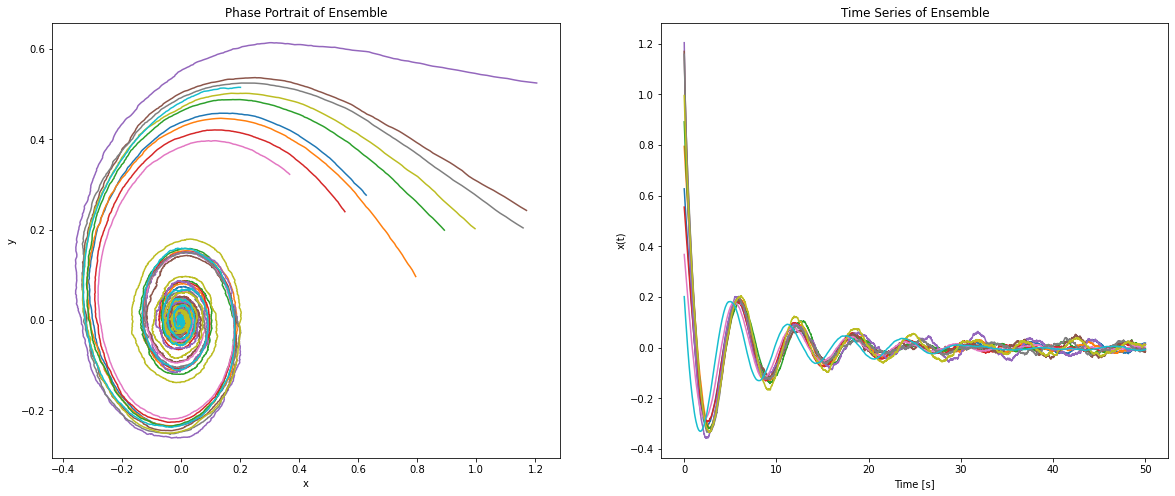

In [454]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
[ax[0].plot(sol_list[i][:,0], sol_list[i][:,1]) for i in range(10)]
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Phase Portrait of Ensemble')
[ax[1].plot(tspan, sol_list[i][:,0]) for i in range(10)]
ax[1].set_title('Time Series of Ensemble')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('x(t)')
plt.show()

In [455]:
TS_HOPF_MU_N005 = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

### 3. $\mu = 0$ 

In [456]:
random.seed(69)
n_samples = 10
ic_initial = [0.8, 0.3]
frac_perturb = 0.8 # fraction (of the ics) to perturb initial conditions by
ics = np.zeros((10, 2))
for i in range(n_samples):
    ic_perturb = 1 + frac_perturb * (2 * np.random.random(len(ic_initial))-1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new

In [457]:
noise = 0.01 # noise amplitude as fraction of ics
dt = 0.01
def f(state, t):
    mu = 0.
    x, y = state[0], state[1]
    dxdt = - y + (mu - x ** 2 - y ** 2) * x
    dydt = x + (mu - x ** 2 - y ** 2) * y
    return dxdt, dydt
tspan = np.arange(0, 50, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)

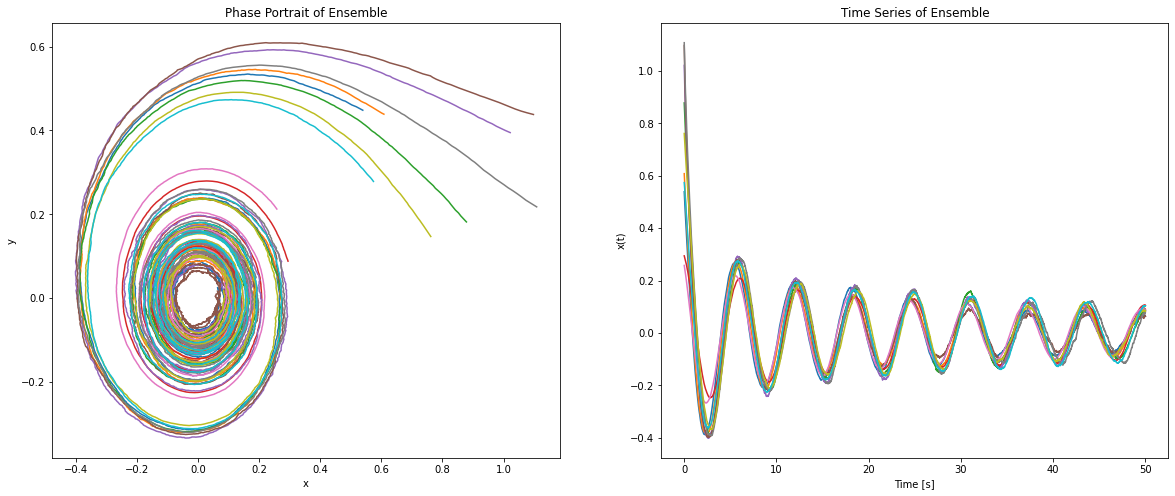

In [458]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
[ax[0].plot(sol_list[i][:,0], sol_list[i][:,1]) for i in range(10)]
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Phase Portrait of Ensemble')
[ax[1].plot(tspan, sol_list[i][:,0]) for i in range(10)]
ax[1].set_title('Time Series of Ensemble')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('x(t)')
plt.show()

Unlike for mu = -0.05, we now have stable orbits about the origin. 

In [459]:
TS_HOPF_MU_0 = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

### 4. $\mu = 0.1$ 

In [460]:
random.seed(420)
n_samples = 10
ic_initial = [0.8, 0.3]
frac_perturb = 0.8 # fraction (of the ics) to perturb initial conditions by
ics = np.zeros((10, 2))
for i in range(n_samples):
    ic_perturb = 1 + frac_perturb * (2 * np.random.random(len(ic_initial))-1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new

In [461]:
noise = 0.01 # noise amplitude as fraction of ics
dt = 0.01
def f(state, t):
    mu = 0.1
    x, y = state[0], state[1]
    dxdt = - y + (mu - x ** 2 - y ** 2) * x
    dydt = x + (mu - x ** 2 - y ** 2) * y
    return dxdt, dydt
tspan = np.arange(0, 50, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)

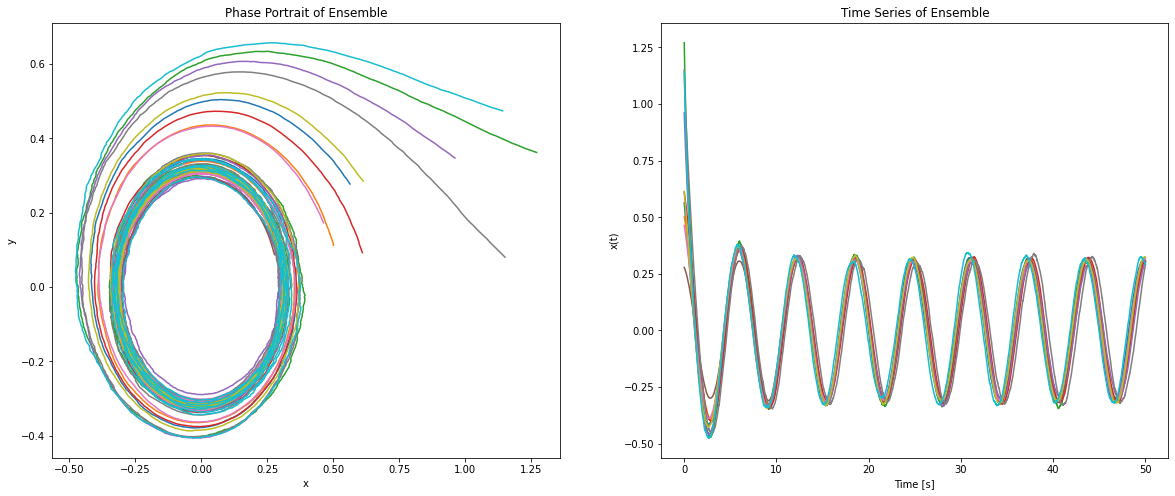

In [462]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
[ax[0].plot(sol_list[i][:,0], sol_list[i][:,1]) for i in range(10)]
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Phase Portrait of Ensemble')
[ax[1].plot(tspan, sol_list[i][:,0]) for i in range(10)]
ax[1].set_title('Time Series of Ensemble')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('x(t)')
plt.show()

This is not a limit cycle as there are infinitely many non-isolated periodic solutions.

In [463]:
TS_HOPF_MU_P005 = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

### 5. $\mu = 10$

In [464]:
random.seed(340)
n_samples = 10
ic_initial = [0.8, 0.3]
frac_perturb = 0.8 # fraction (of the ics) to perturb initial conditions by
ics = np.zeros((10, 2))
for i in range(n_samples):
    ic_perturb = 1 + frac_perturb * (2 * np.random.random(len(ic_initial))-1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new

In [465]:
noise = 0.01 # noise amplitude as fraction of ics
dt = 0.01
def f(state, t):
    mu = 10.
    x, y = state[0], state[1]
    dxdt = - y + (mu - x ** 2 - y ** 2) * x
    dydt = x + (mu - x ** 2 - y ** 2) * y
    return dxdt, dydt
tspan = np.arange(0, 50, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)

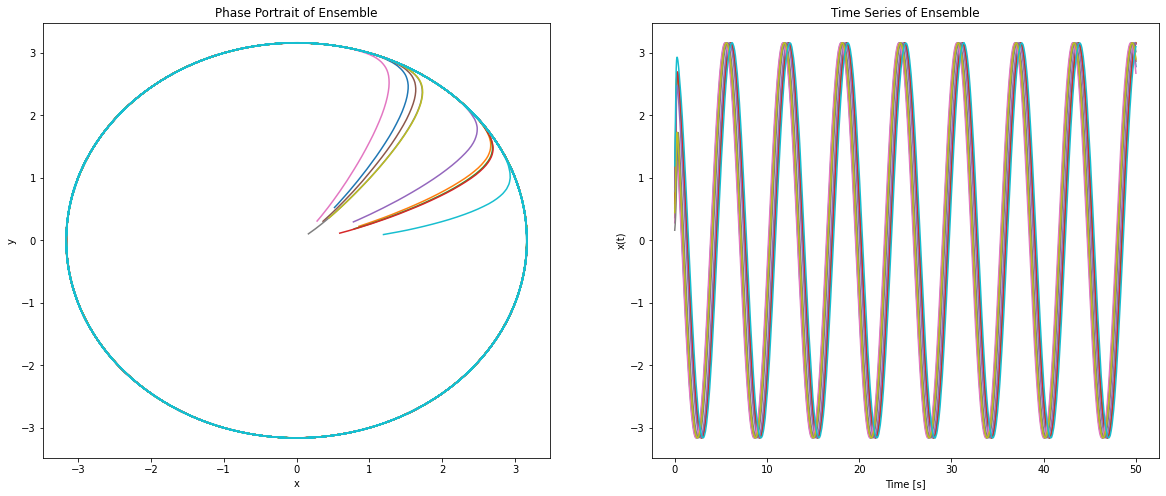

In [466]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
[ax[0].plot(sol_list[i][:,0], sol_list[i][:,1]) for i in range(10)]
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Phase Portrait of Ensemble')
[ax[1].plot(tspan, sol_list[i][:,0]) for i in range(10)]
ax[1].set_title('Time Series of Ensemble')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('x(t)')
plt.show()

Wow. Now this is a limit cycle! All ic's attract onto a stable limit cycle with a constant period. We can see an isolated periodic orbit as opposed to that for my = 0.1 where there are infinitely many period solutions (which is not a limit cycle). Since it is isolated, every single trajectory will attract onto a single period solution. 

In [467]:
TS_HOPF_MU_P10 = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

In [468]:
#TS_HOPF_MU_N10
#TS_HOPF_MU_N01
#TS_HOPF_MU_0
#TS_HOPF_MU_P01
#TS_HOPF_MU_P10

In [469]:
tsData = [TS_HOPF_MU_N10, TS_HOPF_MU_N005, TS_HOPF_MU_0, TS_HOPF_MU_P005, TS_HOPF_MU_P10]

In [470]:
tsData[0][1].shape

(10, 4500)

## Inspect All Regimes Time Series

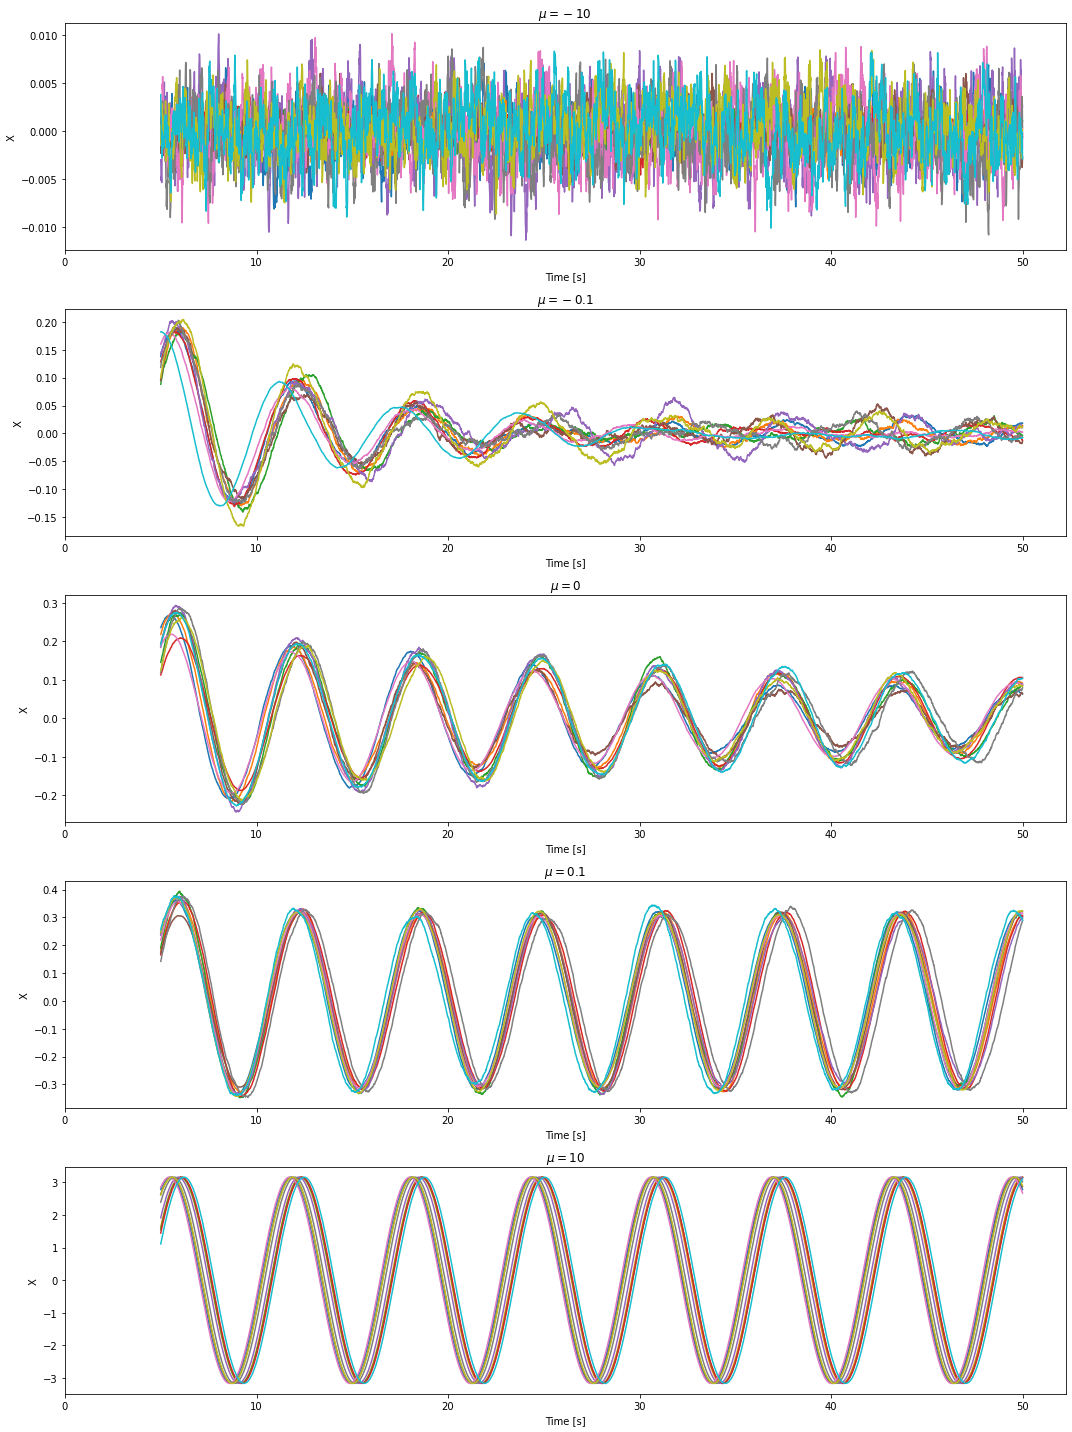

In [471]:
tsData = [TS_HOPF_MU_N10, TS_HOPF_MU_N005, TS_HOPF_MU_0, TS_HOPF_MU_P005, TS_HOPF_MU_P10]
names = ['$\mu = -10$', '$\mu = -0.1$', '$\mu = 0$', '$\mu = 0.1$', '$\mu = 10$']
fig, axes = plt.subplots(5, 1, figsize=(15, 20))
for index, ax in enumerate(axes.ravel()):
    [ax.plot(tsData[index][0][500:], tsData[index][1][i,:]) for i in range(10)]
    ax.set_title(names[index])
    ax.set_xlim(left=0)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('X')
fig.tight_layout()

## Catch22 Feature Extraction

In [472]:
TS_HOPF_MU_N10[1].shape

(10, 4500)

In [473]:
FEATURES_HOPF_MU_N10 = np.array([catch22.catch22_all(TS_HOPF_MU_N10[1][i,:])['values'] for i in range(10)])
FEATURES_HOPF_MU_N10.shape

(10, 22)

In [474]:
FEATURES_HOPF_MU_N005 = np.array([catch22.catch22_all(TS_HOPF_MU_N005[1][i,:])['values'] for i in range(10)])
FEATURES_HOPF_MU_0 = np.array([catch22.catch22_all(TS_HOPF_MU_0[1][i,:])['values'] for i in range(10)])
FEATURES_HOPF_MU_P005 = np.array([catch22.catch22_all(TS_HOPF_MU_P005[1][i,:])['values'] for i in range(10)])
FEATURES_HOPF_MU_P10 = np.array([catch22.catch22_all(TS_HOPF_MU_P10[1][i,:])['values'] for i in range(10)])
FEATURES_LIST = [FEATURES_HOPF_MU_N10, FEATURES_HOPF_MU_N005, FEATURES_HOPF_MU_0, FEATURES_HOPF_MU_P005, FEATURES_HOPF_MU_P10]

## Standardise Features

In [475]:
FEATURES_ARRAY = np.vstack([FEATURES_LIST[i] for i in range(len(FEATURES_LIST))])
normalized_features = StandardScaler().fit_transform(FEATURES_ARRAY)

In [476]:
normalized_features.shape

(50, 22)

## Apply PCA

So all of the instances are grouped together. This should be okay as long as we have a record of the order with which they occur in the array.

In [477]:
pca_reducer = PCA(n_components=2)
embedding = pca_reducer.fit_transform(normalized_features)

In [478]:
embedding.shape

(50, 2)

Seperate into individual arrays for convenience with labelling etc.

In [479]:
mu_n_10 = embedding[:10, :]
mu_n_005 = embedding[10:20, :]
mu_0 = embedding[20:30, :]
mu_p_005 = embedding[30:40, :]
mu_p_10 = embedding[40:50, :]

## Visualise 

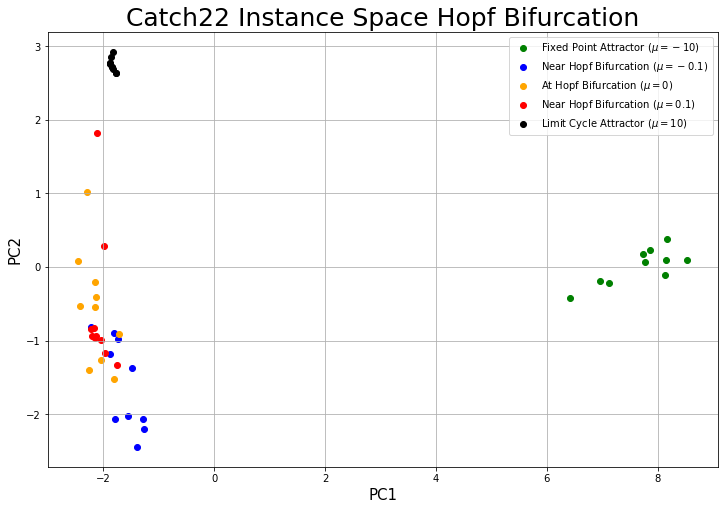

In [480]:
plt.figure(figsize=(12, 8))
plt.scatter(mu_n_10[:,0], mu_n_10[:,1], color='green', label = 'Fixed Point Attractor ($\mu = -10$)')
plt.scatter(mu_n_005[:,0], mu_n_005[:,1], color='blue', label = 'Near Hopf Bifurcation ($\mu = -0.1$)')
plt.scatter(mu_0[:,0], mu_0[:,1], color='orange', label = 'At Hopf Bifurcation ($\mu = 0$)')
plt.scatter(mu_p_005[:,0], mu_p_005[:,1], color='red',label = 'Near Hopf Bifurcation ($\mu = 0.1$)') 
plt.scatter(mu_p_10[:,0], mu_p_10[:,1], color='black', label = 'Limit Cycle Attractor ($\mu = 10$)')
plt.legend()
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Catch22 Instance Space Hopf Bifurcation', fontsize=25)
plt.grid()
plt.show()

We can see clear separation between fixed point dynamics/attractors (green) on the far right and oscillatory dynamics (everything on the left). This is just for one noise-level. How robust is this separation with increasing levels of noise? Also, how do the positions of instances evolve in this space as a function of control parameter mu?

## Bistability with Hysteresis

The normal form of the stabilised subcritical pitchfork bifurcation is:
$$\dot{x} = \lambda + x - x^3$$
There are several regimes:
- Fixed point attractor regime
- Multistability regime 

<img src = "resources/bistable_hysteresis.png" width=500, height=400>

## 1. Fixed Point Attractor Regime $\lambda = -2$ (Lower Stable Branch), Low Noise, eta = 0.001
- Ideally, this should produce similar dynamics to that of the Hopf bifurcation, far from the bifurcation point (to the left).

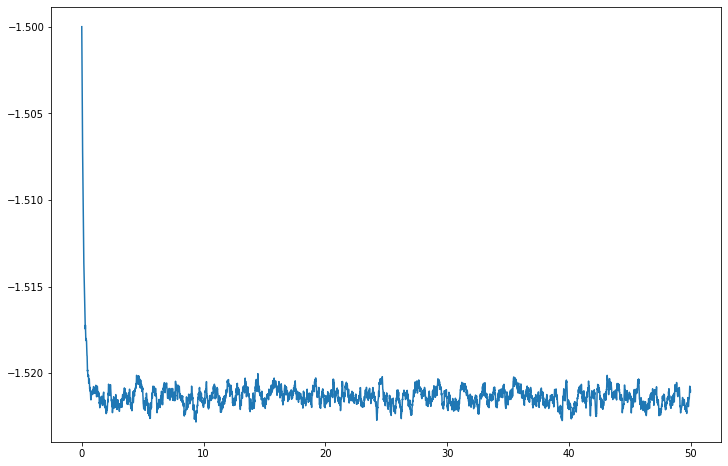

In [481]:
noise = 0.001
dt = 0.01
ic = np.array([-1.5])
def f(state, t):
    r = -2
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 50, dt)
gw = lambda y, t: noise * np.diag(ic) # noise is relative to ic's 
fw = lambda y, t: np.array(f(y,t))
sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
plt.figure(figsize=(12,8))
plt.plot(tspan, sol)
plt.show()

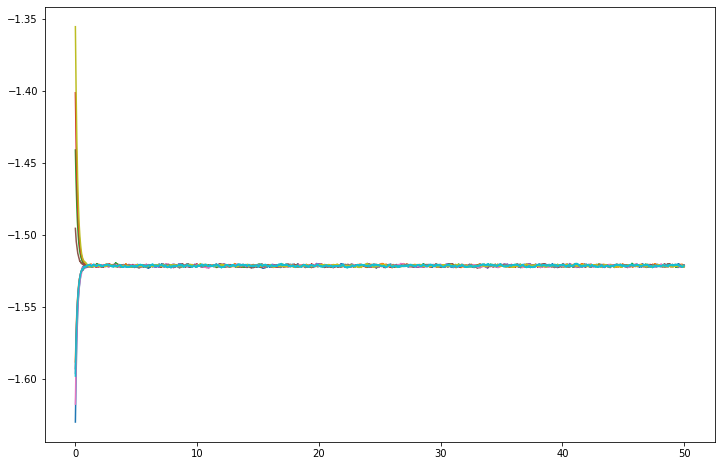

In [482]:
random.seed(435)
n_samples = 10
ic_initial = [-1.5] 
frac_perturb = 0.1
ics = np.zeros((10,1))
for i in range(n_samples): # +/- one order of magnitude smaller than ic perturbation 
    ic_perturb = 1 + frac_perturb * (2* np.random.random(len(ic_initial)) - 1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new
noise = 0.001
dt = 0.01
def f(state, t):
    r = -2
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 50, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic)
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)
plt.figure(figsize=(12,8))
[plt.plot(tspan, sol_list[i]) for i in range(10)]
plt.show()

In [483]:
TS_BISTABLE_LAM_N2 = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

## 2. Bistable Region $\lambda = 0$, low noise, eta = 0.001 - fixed point attractor 

This is where the interesting stuff happens. While the lower branch is locally stable, if noise levels are sufficient, we could get switching where the trajectories attract to the upper stable branch and vice-versa. For time series data, it may be prudent to get instances over a range of noise levels. 

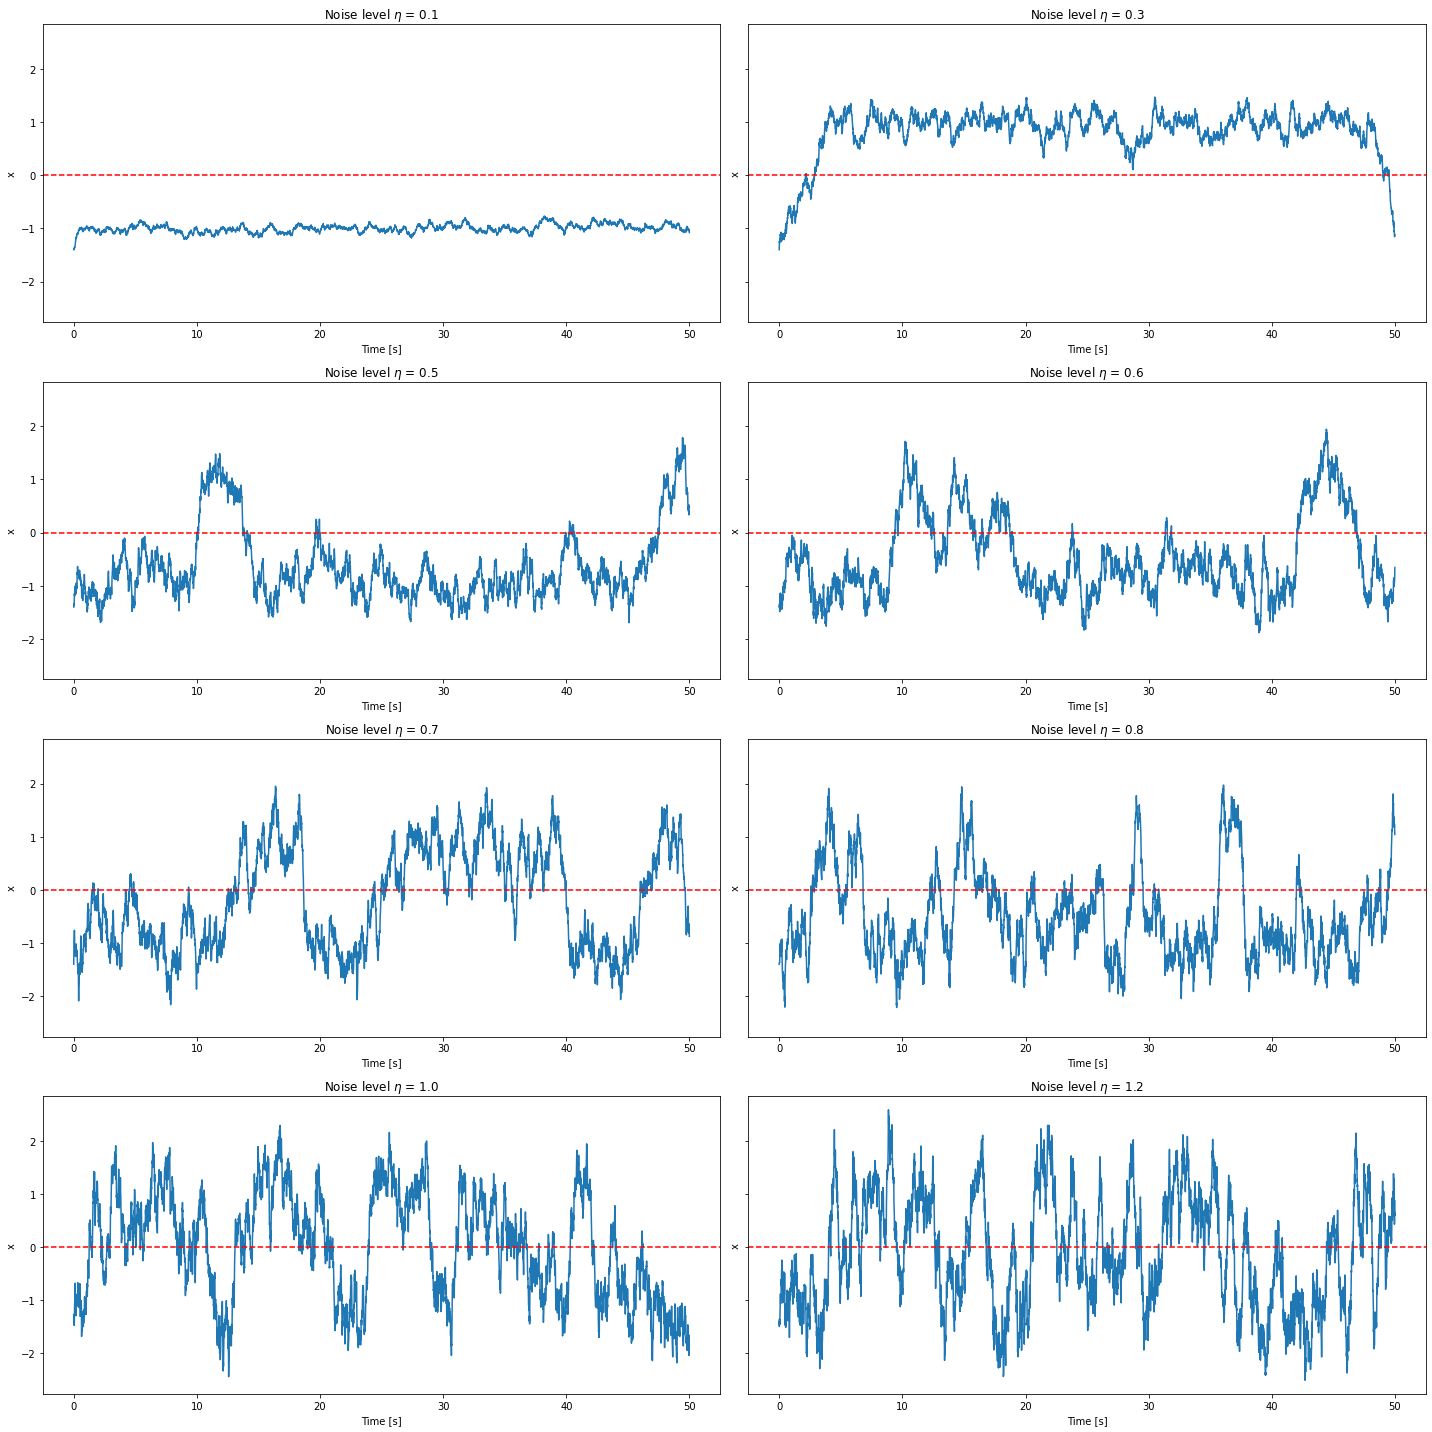

In [484]:
np.random.seed(42)
noise_levels = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2]
dt = 0.01
ic = np.array([-1.4])
def f(state, t):
    r = 0
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 50, dt)
fig, axes = plt.subplots(4,2, figsize=(20,20), sharey=True)
for index, ax in enumerate(axes.ravel()):
    gw = lambda y, t: noise_levels[index] * np.diag(ic) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    ax.plot(tspan, sol)
    ax.set_xlabel('Time [s]')
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_ylabel('x')
    ax.set_title('Noise level $\eta$ = {}'.format(noise_levels[index]))
plt.tight_layout()
plt.show()

Around noise level 0.5 to 0.6, we start to observe bistable switching between stable fixed points from the lower branch to the upper branch. As the noise level continues to increase, the frequency with which the trajectory explores the upper branch increases. If we continue increasing the noise level, we should reach a point at which we exit the 'potential well' and no longer 'see' the dynamics.

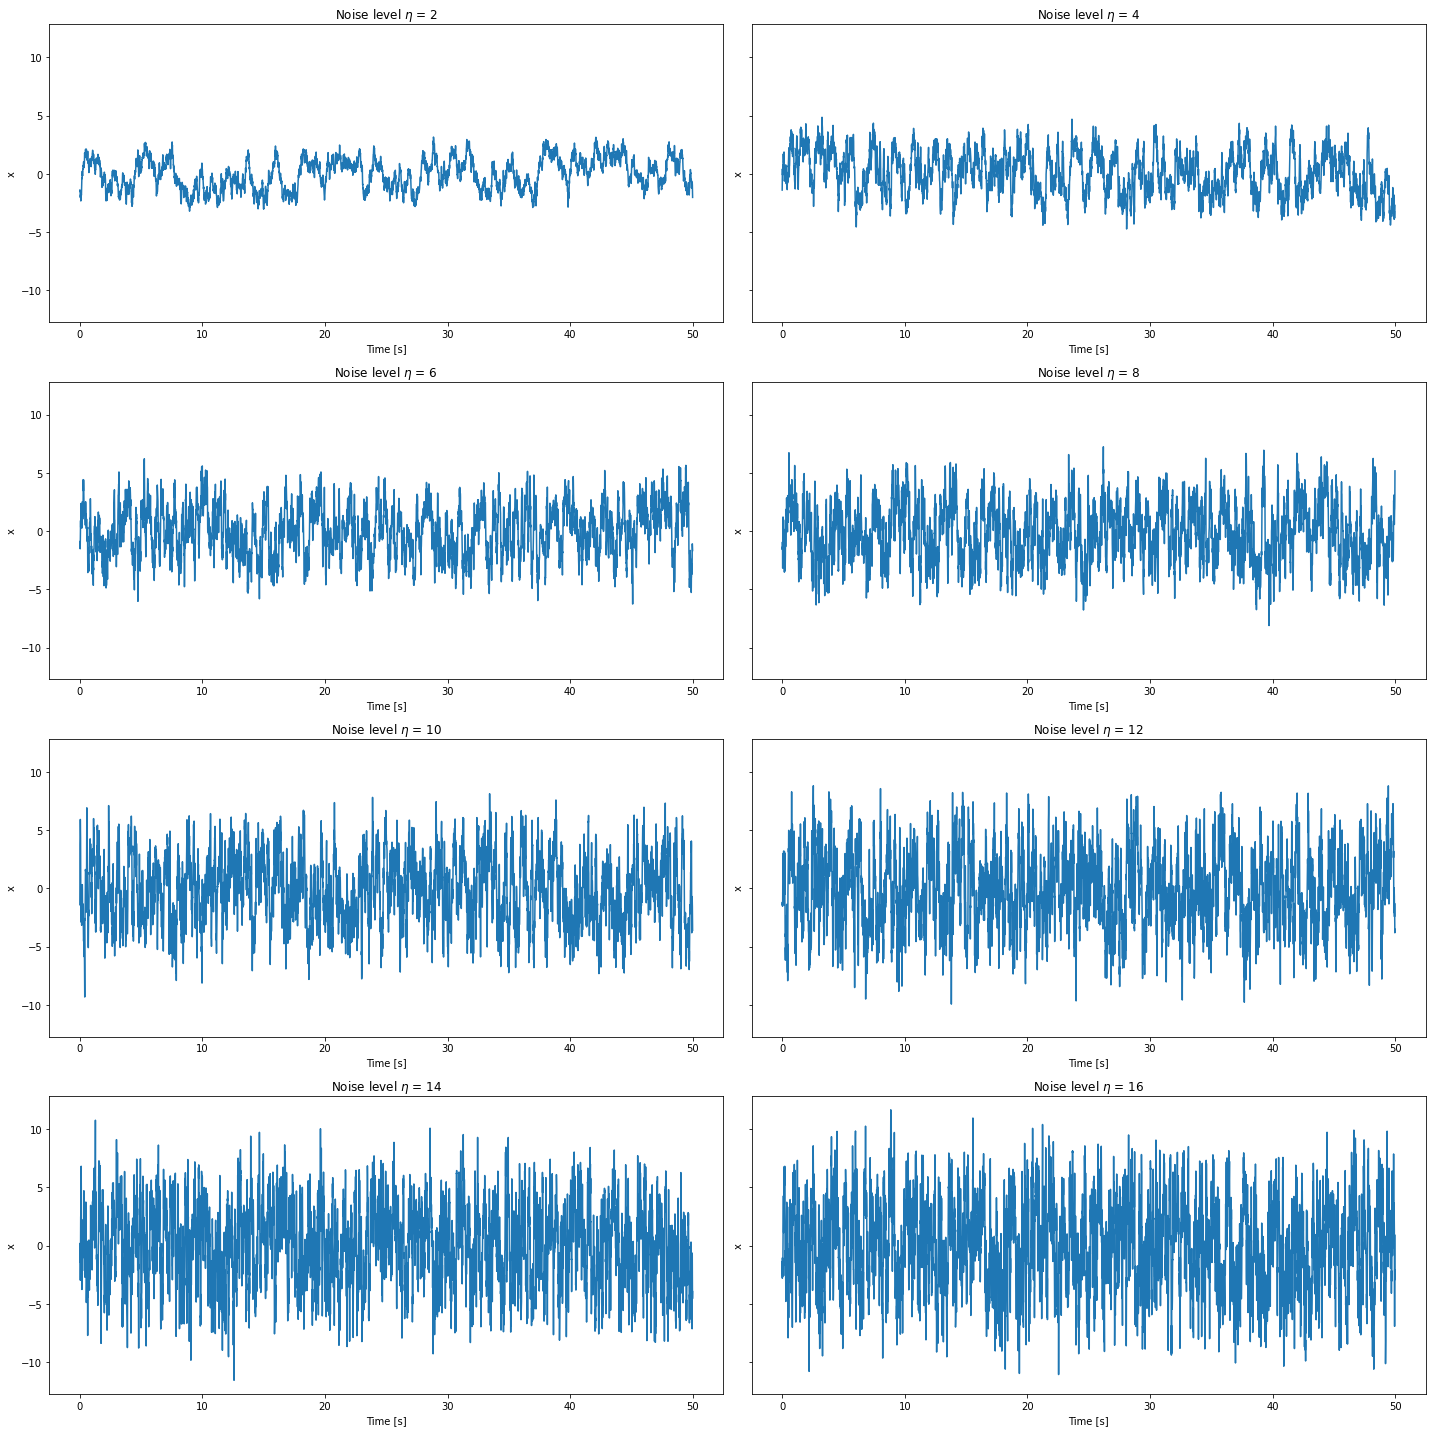

In [485]:
np.random.seed(42)
noise_levels = [2, 4, 6, 8, 10, 12, 14, 16]
dt = 0.01
ic = np.array([-1.4])
def f(state, t):
    r = 0
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 50, dt)
fig, axes = plt.subplots(4,2, figsize=(20,20), sharey=True)
for index, ax in enumerate(axes.ravel()):
    gw = lambda y, t: noise_levels[index] * np.diag(ic) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    ax.plot(tspan, sol)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('x')
    ax.set_title('Noise level $\eta$ = {}'.format(noise_levels[index]))
plt.tight_layout()
plt.show()

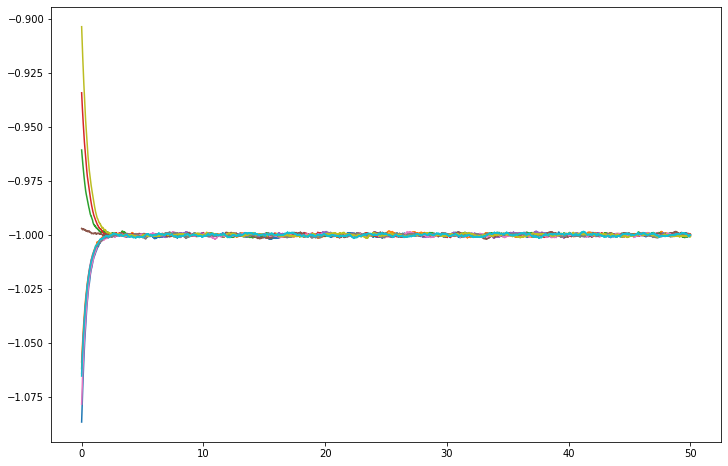

In [532]:
random.seed(435)
n_samples = 10
ic_initial = [-1]
frac_perturb = 0.1
ics = np.zeros((10,1))
for i in range(n_samples):
    ic_perturb = 1 + frac_perturb * (2* np.random.random(len(ic_initial)) - 1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new
noise = 0.001
dt = 0.01
def f(state, t):
    r = 0
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 50, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic)
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)
plt.figure(figsize=(12,8))
[plt.plot(tspan, sol_list[i]) for i in range(10)]
plt.show()

In [534]:
TS_BISTABLE_LAM_0_LowNoise = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

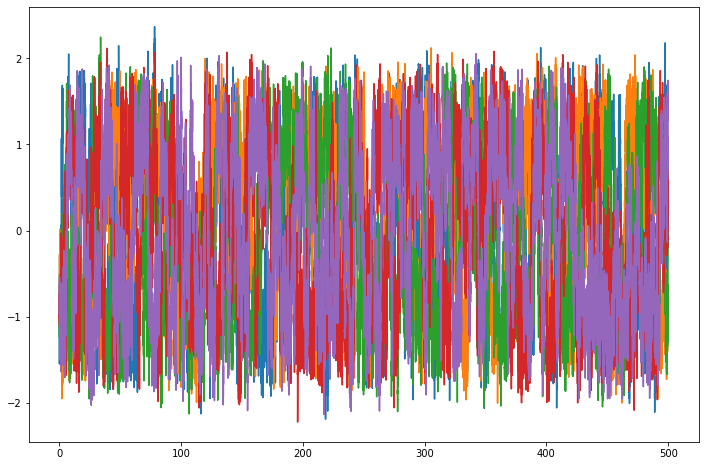

In [558]:
random.seed(4385)
n_samples = 10
ic_initial = [-1]
frac_perturb = 0.1
ics = np.zeros((10,1))
for i in range(n_samples):
    ic_perturb = 1 + frac_perturb * (2* np.random.random(len(ic_initial)) - 1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new
noise = 1.
dt = 0.01
def f(state, t):
    r = 0
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 500, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic)
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)
plt.figure(figsize=(12,8))
[plt.plot(tspan, sol_list[i]) for i in range(5)]
plt.show()

In [559]:
TS_BISTABLE_LAM_0_HighNoise = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

## 3. Fixed point attractor regime $\lambda = 2 $ (Stable Upper branch), Low Noise, eta = 0.001

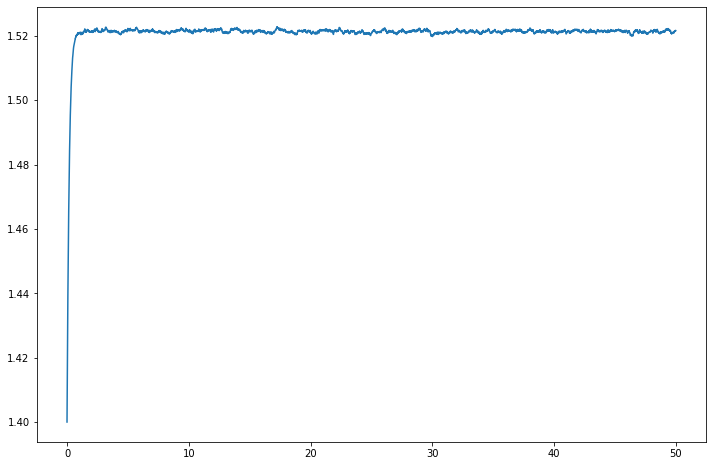

In [546]:
noise = 0.001
dt = 0.01
ic = np.array([1.4])
def f(state, t):
    r = 2
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 50, dt)
gw = lambda y, t: noise * np.diag(ic) # noise is relative to ic's 
fw = lambda y, t: np.array(f(y,t))
sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
plt.figure(figsize=(12,8))
plt.plot(tspan, sol)
plt.show()

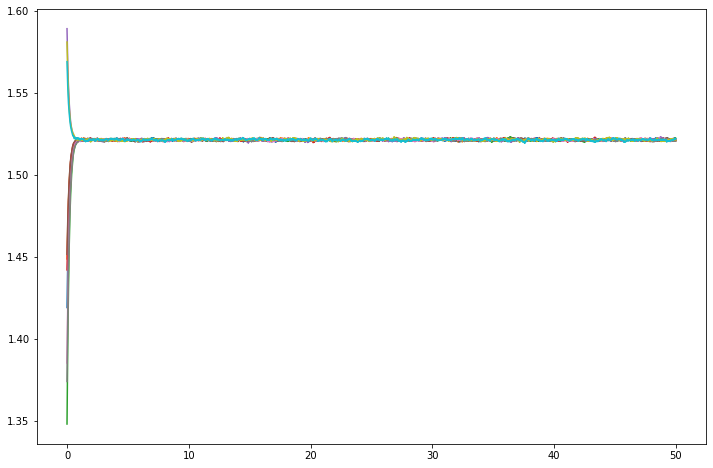

In [547]:
random.seed(9565)
n_samples = 10
ic_initial = [1.45]
frac_perturb = 0.1
ics = np.zeros((10,1))
for i in range(n_samples):
    ic_perturb = 1 + frac_perturb * (2* np.random.random(len(ic_initial)) - 1)
    ic_new = ic_initial * ic_perturb
    ics[i, :] = ic_new
noise = 0.001
dt = 0.01
def f(state, t):
    r = 2
    x = state
    dxdt = r + x - x**3
    return dxdt 
tspan = np.arange(0, 50, dt)
sol_list = list()
for index, ic in enumerate(ics):
    ic = np.array(ic)
    gw = lambda y, t: noise * np.diag(ic)
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol_list.append(sol)
plt.figure(figsize=(12,8))
[plt.plot(tspan, sol_list[i]) for i in range(10)]
plt.show()

In [548]:
TS_BISTABLE_LAM_P2 = [tspan, np.array([sol_list[i][500:,0] for i in range(len(sol_list))])]

### Feature Extraction + PCA + Visualisation

In [560]:
FEATURES_BISTABLE_LAM_N2 = np.array([catch22.catch22_all(TS_BISTABLE_LAM_N2[1][i,:])['values'] for i in range(10)])
FEATURES_BISTABLE_LAM_0_LowNoise = np.array([catch22.catch22_all(TS_BISTABLE_LAM_0_LowNoise[1][i,:])['values'] for i in range(10)])
FEATURES_BISTABLE_LAM_0_HighNoise = np.array([catch22.catch22_all(TS_BISTABLE_LAM_0_HighNoise[1][i,:])['values'] for i in range(10)])
FEATURES_BISTABLE_LAM_P2 = np.array([catch22.catch22_all(TS_BISTABLE_LAM_P2[1][i,:])['values'] for i in range(10)])
FEATURES_LIST_BISTABLE = [FEATURES_BISTABLE_LAM_N2, FEATURES_BISTABLE_LAM_0_LowNoise, FEATURES_BISTABLE_LAM_0_HighNoise, FEATURES_BISTABLE_LAM_P2]
FEATURES_BISTABLE_ARRAY = np.vstack([FEATURES_LIST_BISTABLE[i] for i in range(len(FEATURES_LIST_BISTABLE))])

In [561]:
normalized_features_bistable = StandardScaler().fit_transform(FEATURES_BISTABLE_ARRAY)
pca_reducer = PCA(n_components=2)
embedding_bistable = pca_reducer.fit_transform(normalized_features_bistable)
lam_n2 = embedding_bistable[:10, :]
lam_0_lowNoise = embedding_bistable[10:20, :]
lam_0_HighNoise = embedding_bistable[20:30, :]
lam_p2 = embedding_bistable[30:40, :]

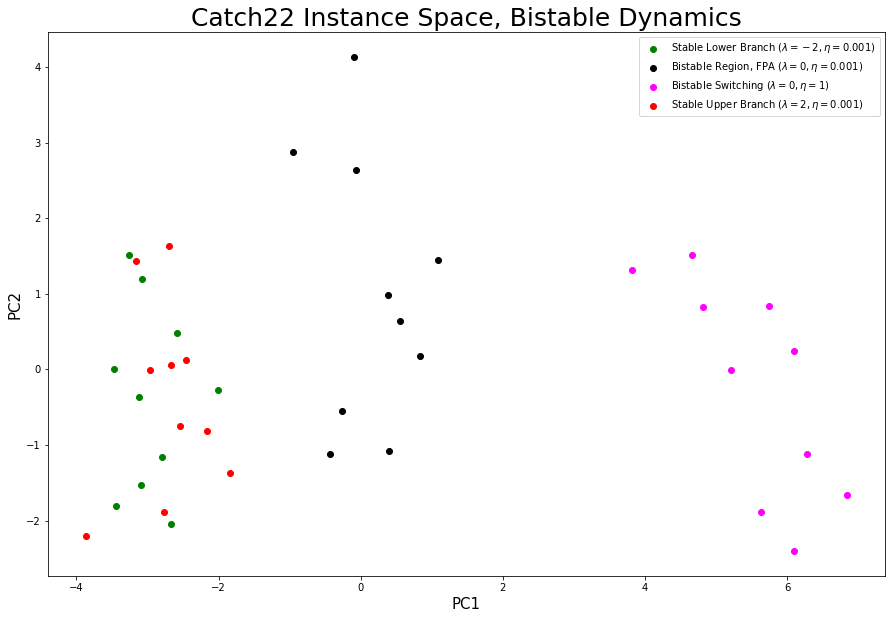

In [562]:
# FPA = Fixed Point Attractor
plt.figure(figsize=(15,10))
plt.scatter(lam_n2[:,0], lam_n2[:,1], color='green', label='Stable Lower Branch ($\lambda = -2, \eta = 0.001$)')
plt.scatter(lam_0_lowNoise[:,0], lam_0_lowNoise[:,1], color='black', label='Bistable Region, FPA ($\lambda = 0, \eta = 0.001$)')
plt.scatter(lam_0_HighNoise[:,0], lam_0_HighNoise[:,1], color='magenta', label='Bistable Switching ($\lambda = 0, \eta = 1$)')
plt.scatter(lam_p2[:,0], lam_p2[:,1], color='red', label='Stable Upper Branch ($\lambda = 2, \eta = 0.001$)')
plt.title('Catch22 Instance Space, Bistable Dynamics', fontsize=25)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.legend()
plt.show()